In [1]:
import numpy as np
import scipy
import pandas as pd
import networkx as nx

In [2]:
known_genes = pd.read_csv('../data/processed/literature/nature_review_als_genes_ensg.csv')
known_genes.head()

,gene_name,pathway,cite,Ensembl_gene_ID
0,SETX,Abbertant RNA metabolism,Hardiman 2017,ENSG00000107290
1,FUS,Abbertant RNA metabolism,Hardiman 2017,ENSG00000089280
2,FUS,Impaired DNA repair,Hardiman 2017,ENSG00000089280
3,ANG,Abbertant RNA metabolism,Hardiman 2017,ENSG00000214274
4,TARDBP,Abbertant RNA metabolism,Hardiman 2017,ENSG00000120948


In [3]:
unique_known_genes = np.unique(known_genes.Ensembl_gene_ID)

In [4]:
len(unique_known_genes)

27

In [5]:
edges = pd.read_csv("/data/nasif12/home_if12/brechtma/Documents/code/ALS/data/common/string_preprocessed.tsv.gz", sep='\t')

In [6]:
edges.head()

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene1,gene2
0,ENSP00000000233,ENSP00000272298,0,0,332,62,181,0,125,490,ENSG00000004059,ENSG00000143933
1,ENSP00000000233,ENSP00000253401,0,0,0,0,186,0,56,198,ENSG00000004059,ENSG00000131089
2,ENSP00000000233,ENSP00000401445,0,0,0,0,159,0,0,159,ENSG00000004059,ENSG00000178607
3,ENSP00000000233,ENSP00000418915,0,0,0,61,158,0,542,606,ENSG00000004059,ENSG00000147889
4,ENSP00000000233,ENSP00000327801,0,0,0,88,78,0,89,167,ENSG00000004059,ENSG00000185624


In [7]:
edges

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene1,gene2
0,ENSP00000000233,ENSP00000272298,0,0,332,62,181,0,125,490,ENSG00000004059,ENSG00000143933
1,ENSP00000000233,ENSP00000253401,0,0,0,0,186,0,56,198,ENSG00000004059,ENSG00000131089
2,ENSP00000000233,ENSP00000401445,0,0,0,0,159,0,0,159,ENSG00000004059,ENSG00000178607
3,ENSP00000000233,ENSP00000418915,0,0,0,61,158,0,542,606,ENSG00000004059,ENSG00000147889
4,ENSP00000000233,ENSP00000327801,0,0,0,88,78,0,89,167,ENSG00000004059,ENSG00000185624
...,...,...,...,...,...,...,...,...,...,...,...,...
11759449,ENSP00000485678,ENSP00000310488,0,0,0,167,0,0,0,167,NaN,ENSG00000174667
11759450,ENSP00000485678,ENSP00000342448,0,0,0,175,0,0,0,175,NaN,ENSG00000187612
11759451,ENSP00000485678,ENSP00000350222,0,0,0,195,0,0,0,195,NaN,ENSG00000197428
11759452,ENSP00000485678,ENSP00000367590,0,0,0,0,0,900,0,900,NaN,ENSG00000132563


In [8]:
edges = edges.dropna()

In [9]:
%%time
string_graph = nx.from_pandas_edgelist(edges, 'gene1', 'gene2', 'combined_score')

CPU times: user 55.9 s, sys: 1.64 s, total: 57.5 s
Wall time: 57.5 s


In [10]:
genes = pd.DataFrame({'gene_id': string_graph.nodes()})

In [11]:
genes

,gene_id
0,ENSG00000004059
1,ENSG00000143933
2,ENSG00000131089
3,ENSG00000178607
4,ENSG00000147889
...,...
18838,ENSG00000255359
18839,ENSG00000255378
18840,ENSG00000229924
18841,ENSG00000260286


In [12]:
idx_of_seeds = genes[np.isin(genes.gene_id, unique_known_genes)].index

In [13]:
p_restart = 0.3

# init matrix of candidate genes
p_init = np.zeros(len(string_graph.nodes()))

p_init[idx_of_seeds] = 1

In [14]:
p_init = p_init/p_init.sum()

In [15]:

# get adjacency matrix and normalize it to obtain transition matrix
adj = nx.to_scipy_sparse_matrix(string_graph, weight='score')
norm_c = scipy.sparse.diags(1/adj.sum(axis=1).A.ravel())
adj = (norm_c @ adj)

# run a few random walk iterations 
p = p_init
for i in range(20):

    p = (1 - p_restart) * adj.T @ p +  p_restart * p_init

In [16]:
genes['score'] = p

In [17]:
genes

,gene_id,score
0,ENSG00000004059,7.849733e-05
1,ENSG00000143933,9.839416e-05
2,ENSG00000131089,2.695956e-05
3,ENSG00000178607,1.217978e-04
4,ENSG00000147889,2.326370e-04
...,...,...
18838,ENSG00000255359,3.100055e-08
18839,ENSG00000255378,1.666046e-07
18840,ENSG00000229924,2.614880e-08
18841,ENSG00000260286,1.479472e-07


In [18]:
genes.to_csv('../data/processed/network_analysis/prob_of_reaching_gene_from_seeds.tsv', sep = '\t')

In [19]:
import plotnine as p9

/opt/modules/i12g/anaconda/envs/geneprofanalysis/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 119'. Pick better value with 'binwidth'.


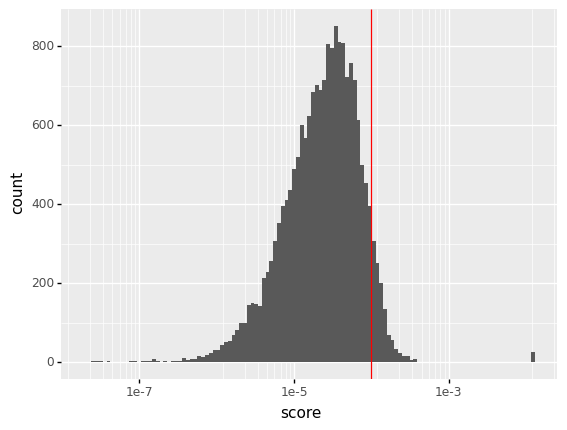

<ggplot: (2950218681209)>

In [20]:
p9.ggplot(genes, p9.aes('score')) + p9.geom_histogram() + p9.scale_x_log10() + p9.geom_vline(xintercept = 1e-4, color = 'red')